In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# PCA in Practice

PCA is used to search for patterns in high-dimensional data. In this section, we discuss when PCA is most appropriate for analysis and introduce captured variance and scree plots. Then, we apply PCA to the legislator voting data and interpret the plot of its principal components.

## When is PCA appropriate?

In Data 100, we primarily use PCA for exploratory data analysis: when we do not yet know what information the dataset captures or what we might use the data to predict. As a dimensionality reduction technique, PCA is useful primarily when our data contain many columns, **and** when we have reason to believe that the data are inherently low rank, that the patterns in the data can be summarized with a linear combination of columns.

For example, the data table of legislator votes contains data for 41 bills: 

In [5]:
df = pd.read_csv('vote_pivot.csv', index_col='member')
df

,515,516,517,518,...,552,553,554,555
member,,,,,,,,,
A000055,1,0,0,0,...,0,0,1,0
A000367,0,0,0,0,...,1,1,0,1
A000369,1,1,0,0,...,0,0,1,0
...,...,...,...,...,...,...,...,...,...
Y000062,1,1,1,1,...,1,1,1,1
Y000065,0,0,0,0,...,0,0,1,0
Z000017,1,1,0,0,...,0,0,1,0


41 columns is too many to visualize directly. However, we expect that most voting tends to fall within party lines. Perhaps 20 bills in the table are strongly supported by the Democratic party, so Republican legislators will vote against these bills while Democratic legislators will vote for these bills. This knowledge suggests that the voting patterns of legislators might be clustered – a few combinations of bills can reveal party affiliations. This domain knowledge suggests that PCA is appropriate.

### Captured Variance and Scree Plots

We use PCA to calculate low-dimensional approximations for high-dimensional data. How accurate are these approximations? To answer this question, we create **scree plots** using the singular values of the data which describe the **captured variance** of each principal component.

Recall that SVD takes a data matrix $ \mathbf{X} $ and produces the matrix factorization $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top}$. We know that the matrix $ \mathbf{V^\top} $ contains the principal directions of $ \mathbf{X} $ and that the product $ \mathbf{U} \mathbf{\Sigma} $ contains the principal components. Now we examine the values in $ \mathbf{\Sigma} $.

SVD requires that $ \mathbf{\Sigma} $ is a diagonal matrix with elements arranged from largest to smallest. The diagonal elements of $ \mathbf{\Sigma} $ are called the **singular values** of $ \mathbf{X} $. Importantly, the relative magnitude of the singular values precisely represent the percent of variance captured by each principal component.

As an example, we examine the singular values of the body measurement data in the `body_data` table.

In [9]:
#http://jse.amstat.org/datasets/fat.txt
body_data = pd.read_fwf("fat.dat.txt", colspecs = [(9, 13), (17, 21), (23, 29), (35, 37),
                                             (39, 45), (48, 53), (57, 61), (64, 69),
                                             (73, 77), (80, 85), (88, 93), (96, 101),
                                             (105, 109), (113, 117), (121, 125), (129, 133),
                                             (137, 141), (145, 149)], 
                  
                  
                  header=None, names = ["% brozek fat", "% siri fat", "density", "age", 
                                       "weight", "height", "adiposity", "fat free weight",
                                       "neck", "chest", "abdomen", "hip", "thigh",
                                       "knee", "ankle", "bicep", "forearm",
                                       "wrist"])
body_data = body_data.drop(41) #drop the weird record

In [8]:
body_data

,% brozek fat,% siri fat,density,age,...,ankle,bicep,forearm,wrist
0,12.6,12.3,1.07,23,...,21.9,32.0,27.4,17.1
1,6.9,6.1,1.09,22,...,23.4,30.5,28.9,18.2
2,24.6,25.3,1.04,22,...,24.0,28.8,25.2,16.6
...,...,...,...,...,...,...,...,...,...
249,28.3,29.3,1.03,72,...,21.5,31.3,27.2,18.0
250,25.3,26.0,1.04,72,...,22.7,30.5,29.4,19.8
251,30.7,31.9,1.03,74,...,24.6,33.7,30.0,20.9


First, we center the data and apply SVD. We display the singular values in $ \mathbf{\Sigma} $ (recall that the `svd` function produces a one-dimensional array rather than a matrix).

In [15]:
from numpy.linalg import svd

cntr_body = body_data - body_data.mean(axis=0)
U, s, Vt = svd(cntr_body, full_matrices=False)
s

array([585.57, 261.06, 166.31,  57.14,  48.16,  39.79,  31.71,  28.91,
        24.23,  22.23,  20.51,  18.96,  17.01,  15.73,   7.72,   4.3 ,
         1.95,   0.04])

The original data has 18 columns, which result in 18 principal components (and 18 principal directions):

In [17]:
pcs = U @ np.diag(s)
pcs.shape

(251, 18)

We often keep only the first two principal components to facilitate further visualization (e.g. scatter plot). How much information do we lose from this approximation? We can quantify this by squaring each element in $ \mathbf{\Sigma} $, then dividing by the sum so all the elements sum to 1.

In [21]:
(s**2) / sum(s**2)

array([0.76, 0.15, 0.06, 0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

The values in this array contain the **captured variance** of each principal component. In this case, the first principal component captures 76% of the variance in the original data. If we keep the first two principal components, we retain 76% + 15% = 91% of the variance in the original data.

A **scree plot** is a plot of the squared singular values and provides a visualization of the captured variance:

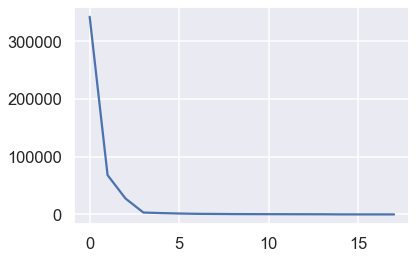

In [23]:
plt.plot(s**2);

Like the numeric values, the scree plot suggests that most of the variance in the data can be captured with 2-3 principal components. For PCA, this usually means that a scatter plot of the first two principal dimensions preserves useful patterns in the data and gives us more confidence in proceeding with PCA.

In contrast, consider the scree plot below which we created from randomly generated data:

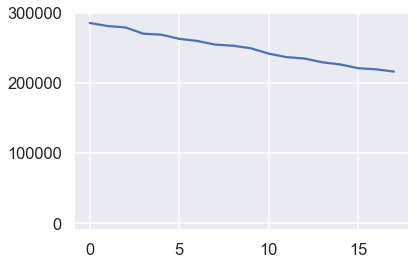

In [33]:
np.random.seed(42)
rd = np.random.normal(loc=0, scale=10, size=(2500, 18))
rd = rd - rd.mean(axis=0)
U, s, Vt = svd(rd, full_matrices=False)
plt.plot(s**2)
plt.ylim(-10000, 300_000);

This plot says that *every* principal component captures a significant amount of variance. This sort of scree plot discourages the use of PCA; a two-dimensional approximation would likely lose useful patterns in the data.

## Case Study: Legislator Votes

Now we return to the legislator vote data, which contains the US House of Representative votes in September 2019. Our goal is to use PCA to reduce the data to two principal components, then use the scatter plot of the principal components to search for patterns in voting.

In [34]:
df

,515,516,517,518,...,552,553,554,555
member,,,,,,,,,
A000055,1,0,0,0,...,0,0,1,0
A000367,0,0,0,0,...,1,1,0,1
A000369,1,1,0,0,...,0,0,1,0
...,...,...,...,...,...,...,...,...,...
Y000062,1,1,1,1,...,1,1,1,1
Y000065,0,0,0,0,...,0,0,1,0
Z000017,1,1,0,0,...,0,0,1,0


First, we perform SVD and examine the scree plot.

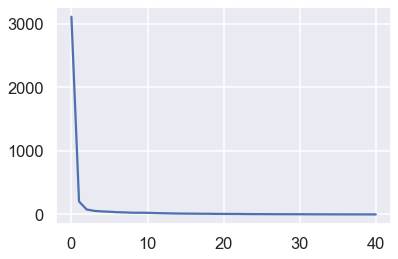

In [36]:
cntr_votes = df - df.mean(axis=0)
U, s, Vt = svd(cntr_votes, full_matrices=False)
plt.plot(s**2);

This plot suggests that a two-dimensional projection from PCA will capture much of the original data's variance. Indeed, we see that this projection captures 85% of the original variance:

In [39]:
s**2 / sum(s**2) # 0.8 + 0.05 = 0.85 captured variance from 2 PCs

array([0.8 , 0.05, 0.02, ..., 0.  , 0.  , 0.  ])

We compute the first two principal components, then use them to create a scatter plot.

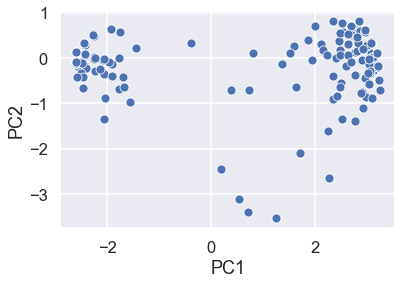

In [45]:
pcs = U @ np.diag(s)
pc1 = pcs[:, 0]
pc2 = pcs[:, 1]
sns.scatterplot(pc1, pc2)
plt.xlabel('PC1')
plt.ylabel('PC2');

How do we interpret this plot? First, we note that there are 441 points in the scatter plot, one for each legislator in the original dataset. The scatter plot reveals that there are roughly two clusters of legislators. Usefully, these clusters neatly capture party affiliations of the legislators!

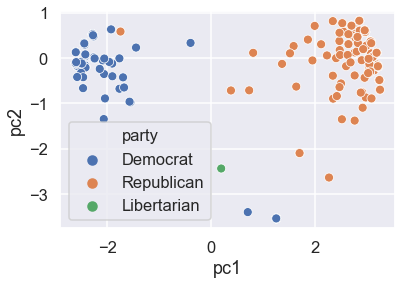

In [54]:
legs = pd.read_csv('legislators.csv')

vote2d = pd.DataFrame({
    'member': df.index,
    'pc1': pcs[:, 0],
    'pc2': pcs[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')
sns.scatterplot(data = vote2d,
                x="pc1", y="pc2", hue="party",
                hue_order=['Democrat', 'Republican', 'Libertarian']);

Note that PCA did not use the party affiliations for its approximation, only the votes. Even though no two legislators voted the exact same way, the votes within party members was similar enough to create two distinct clusters using PCA. In real-world scenarios, we might not know ahead of time that there are roughly two categories of people in the data. PCA is useful in these scenarios because it can alert us to patterns in data that we hadn't considered before. For example, in this scenario we might also conclude that Democrat party members tend to vote more closely within party lines than Republican party members since the Democrat members cluster more tightly together in the scatter plot.

### Examining the First Principal Direction

We can also examine the principal directions themselves. The scatter plot of principal components suggest that the first principal direction captures party affiliation – smaller values in the first principal component correspond to Democratic party members while larger values correspond to Republican members.

We can plot the magnitude of values in the first principal direction:

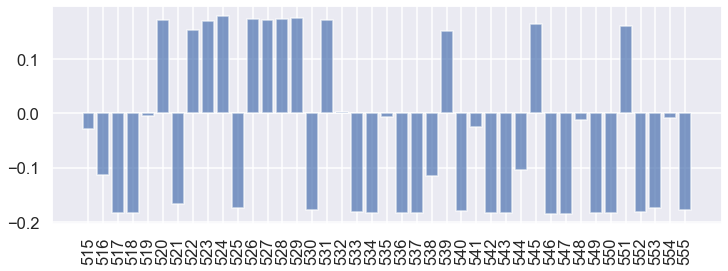

In [50]:
votes = df.columns
plt.figure(figsize=(12, 4))
plt.bar(votes, Vt[0, :], alpha=0.7)
plt.xticks(votes, rotation=90);

For a point to have a large positive value in the first principal component, the legislator needed to vote for bills where the first principal direction contains positive values, and vote against bills where the direction contains negative values.

This implies that we might label bills like 520, 522, and 523 as "Republican" bills and bills like 517 and 518 as "Democratic" bills. To verify this, we can inspect the votes of the legislators with the largest values in the first principal component:

In [53]:
vote2d.sort_values('pc1', ascending=False).head(3)

,member,pc1,pc2,leg_id,...,state,chamber,party,birthday
134,G000552,3.24,-0.70,G000552,...,TX,rep,Republican,1953-08-18
39,B001302,3.24,-0.70,B001302,...,AZ,rep,Republican,1958-11-07
334,R000614,3.23,-0.48,R000614,...,TX,rep,Republican,1972-08-07


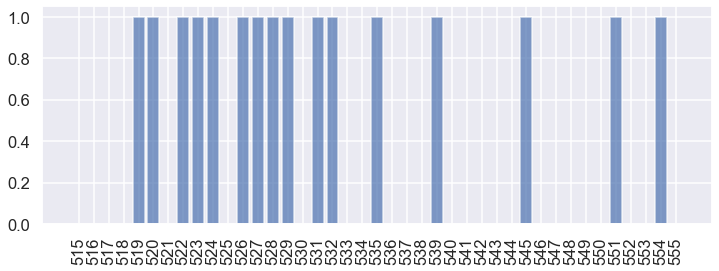

In [61]:
mem = 'G000552'
plt.figure(figsize=(12, 4))
plt.bar(votes, df.loc[mem], alpha=0.7)
plt.xticks(votes, rotation=90);

Indeed, this legislator voted for bills 520, 522, and 523; they also voted against bills 517 and 518.

## Summary

This chapter introduced the idea of dimensionality reduction which enables us to explore and analyze data that have many columns. We specifically introduced principal component analysis, one common and useful method for dimensionality reduction based on the singular value decomposition. We discussed the procedure for performing PCA, scenarios where PCA is appropriate, and how to use PCA to search for patterns in data.